In [46]:
!pip install catboost -qU

In [47]:
!pip freeze | grep "numpy\|pandas\|scikit-learn\|catboost\|torch\|tqdm\|matplotlib"

catboost==1.2.3
geopandas==0.13.2
matplotlib==3.7.1
matplotlib-inline==0.1.6
matplotlib-venn==0.11.10
numpy==1.25.2
pandas==1.5.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==1.5.3.230304
scikit-learn==1.2.2
sklearn-pandas==2.2.0
torch @ https://download.pytorch.org/whl/cu121/torch-2.2.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=1adf430f01ff649c848ac021785e18007b0714fdde68e4e65bd0c640bf3fb8e1
torchaudio @ https://download.pytorch.org/whl/cu121/torchaudio-2.2.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=23f6236429e2bf676b820e8e7221a1d58aaf908bff2ba2665aa852df71a97961
torchdata==0.7.1
torchsummary==1.5.1
torchtext==0.17.1
torchvision @ https://download.pytorch.org/whl/cu121/torchvision-0.17.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=27af47915f6e762c1d44e58e8088d22ac97445668f9f793524032b2baf4f34bd
tqdm==4.66.2


In [48]:
# Опционально при запуске из колаба

from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


#### Импорты и проверка файлов

In [49]:
import warnings
import random
import os

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
warnings.filterwarnings("ignore")

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

PATH = "/content/drive/MyDrive/Alfa_bank/"
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

EPOCHS = 20 # 20 1
N_FOLDS = 5 # 5 2

/content/drive/MyDrive/Alfa_bank/test_data.pqt
/content/drive/MyDrive/Alfa_bank/feature_description.xlsx
/content/drive/MyDrive/Alfa_bank/sample_submission.csv
/content/drive/MyDrive/Alfa_bank/cluster_weights.xlsx
/content/drive/MyDrive/Alfa_bank/train_data.pqt
/content/drive/MyDrive/Alfa_bank/archive.zip
/content/drive/MyDrive/Alfa_bank/submission_ctb_alpha_purple_smart_filling.csv
/content/drive/MyDrive/Alfa_bank/submission_ctb_alpha_purple_smart_best_parametrs.csv
/content/drive/MyDrive/Alfa_bank/submission_ctb_alpha_purple_smart_AUC.csv
/content/drive/MyDrive/Alfa_bank/Untitled0.ipynb
/content/drive/MyDrive/Alfa_bank/submission_ctb.csv
/content/drive/MyDrive/Alfa_bank/submission_ctb_alpha_purple_AUC_good.csv
/content/drive/MyDrive/Alfa_bank/submission_nn.csv
/content/drive/MyDrive/Alfa_bank/submission_avg.csv
/content/drive/MyDrive/Alfa_bank/best_model_nn.pth


#### Загрузка данных и обработка

In [50]:
train_df = pd.read_parquet(PATH+"train_data.pqt")
test_df = pd.read_parquet(PATH+"test_data.pqt")

cat_cols = ["channel_code", "city", "city_type", "okved", "segment", "start_cluster",
            "index_city_code", "ogrn_month", "ogrn_year"]

train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)
train_df[cat_cols] = train_df[cat_cols].astype(str)
test_df[cat_cols] = test_df[cat_cols].astype(str)

# Кастомная метрика соревнования
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

cluster_weights = pd.read_excel(PATH+"cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

#### Модель для восстановления пропусков классов

In [51]:
main = pd.concat([train_df.drop(columns=['end_cluster']), test_df[test_df.start_cluster!='0']])
main = main.sort_values(by=['id', 'date'])
main['start_cluster_1'] = main.groupby('id')['start_cluster'].shift(1)
main['start_cluster_2'] = main.groupby('id')['start_cluster'].shift(2)
main.replace([np.inf, -np.inf], np.nan, inplace=True)
main.fillna(0, inplace=True)

In [52]:
# Обучение модели

cat_cols_short = [el for el in cat_cols if el != 'start_cluster'] + ['start_cluster_1', 'start_cluster_2']

strat_kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

X, y = main, main["start_cluster"]
scores = []
models_to_fill = []
for train_index, valid_index in strat_kfold.split(main, main['start_cluster']):

    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    model = CatBoostClassifier(
        iterations = 1000,
        depth=4,
        learning_rate=0.03,
        cat_features = cat_cols_short,
        early_stopping_rounds=100,
        loss_function='MultiClass',
        task_type="GPU", devices='0:1'
    )

    model.fit(Pool(X_train.drop(["id", "date", "start_cluster"], axis=1), y_train, cat_features=cat_cols_short),
              eval_set=Pool(X_val.drop(["id", "date", "start_cluster"], axis=1), y_val, cat_features=cat_cols_short),
              verbose=400)
    models_to_fill.append(model)

    y_pred_proba = model.predict_proba(X_val.drop(["id", "date", "start_cluster"], axis=1))
    scores.append(weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict))
    print(weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict))

print(np.mean(scores))

0:	learn: 2.5363693	test: 2.5366467	best: 2.5366467 (0)	total: 28.4ms	remaining: 28.3s
400:	learn: 0.4224627	test: 0.4230423	best: 0.4230423 (400)	total: 9.36s	remaining: 14s
800:	learn: 0.3937677	test: 0.3959217	best: 0.3959217 (800)	total: 18.5s	remaining: 4.59s
999:	learn: 0.3859894	test: 0.3890289	best: 0.3890289 (999)	total: 23.1s	remaining: 0us
bestTest = 0.389028946
bestIteration = 999
0.9719472494765988
0:	learn: 2.5430653	test: 2.5433520	best: 2.5433520 (0)	total: 27.3ms	remaining: 27.3s
400:	learn: 0.4210195	test: 0.4222544	best: 0.4222544 (400)	total: 9.34s	remaining: 13.9s
800:	learn: 0.3941152	test: 0.3969042	best: 0.3969042 (800)	total: 18.5s	remaining: 4.6s
999:	learn: 0.3864130	test: 0.3898949	best: 0.3898949 (999)	total: 23.1s	remaining: 0us
bestTest = 0.3898949388
bestIteration = 999
0.9742527318825958
0:	learn: 2.5363950	test: 2.5366301	best: 2.5366301 (0)	total: 28.6ms	remaining: 28.5s
400:	learn: 0.4215708	test: 0.4236339	best: 0.4236339 (400)	total: 9.28s	remainin

In [53]:
# Важность признаков

imp = pd.DataFrame({
        'name': main.drop(["id", "date", 'start_cluster'], axis=1).columns.to_list(),
        'imp': models_to_fill[0].get_feature_importance()
    }).sort_values('imp', ascending=False)
imp[:30]

,name,imp
89,start_cluster_1,22.162147
56,cnt_a_oper_3m,13.427031
69,cnt_cred_e_oper_3m,5.745567
58,cnt_b_oper_3m,4.069492
68,sum_cred_e_oper_3m,4.067683
17,segment,3.882252
2,balance_amt_min,3.766430
65,sum_deb_e_oper_3m,3.541784
16,okved,2.798060
4,channel_code,2.663315


#### Модель для предикта end_cluster

In [54]:
train_df = train_df.sort_values(by=['id', 'date'])
train_df['start_cluster_1'] = train_df.groupby('id')['start_cluster'].shift(1)
train_df['start_cluster_2'] = train_df.groupby('id')['start_cluster'].shift(2)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)

In [55]:
# Ленивое добавление фичей
# Просто делаем сдвиги для важных фичей

features_for_shift = ['segment', 'okved', 'index_city_code', 'balance_amt_max', 'balance_amt_min',
                      'cnt_c_oper_1m', 'channel_code', 'city', 'sum_cred_e_oper_1m',
                      'cnt_days_deb_e_oper_3m', 'sum_of_paym_1y', 'ft_registration_date',
                      'cnt_deb_e_oper_1m', 'sum_deb_e_oper_3m', 'balance_amt_avg',
                      'cnt_days_cred_e_oper_1m', 'sum_cred_e_oper_3m', 'min_founderpres',
                      'ogrn_year', 'sum_of_paym_2m', 'balance_amt_day_avg', 'sum_deb_h_oper_1m',
                      'cnt_cred_e_oper_1m']
features_for_shift_in_cat_cols = [el for el in features_for_shift if el in cat_cols]
dop_cat_cols = []

for col in features_for_shift_in_cat_cols:
    dop_cat_cols.append(col+'_1')
    dop_cat_cols.append(col+'_2')

for col in features_for_shift:
    train_df[col+'_1'] = train_df.groupby('id')[col].shift(1)
    train_df[col+'_2'] = train_df.groupby('id')[col].shift(2)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)

In [56]:
# Еще ленивое добавление. Перемножаем важные фичи

features_for_mult = [el for el in features_for_shift if el not in cat_cols]
for i in features_for_mult:
    for j in features_for_mult:
        if i != j:
            train_df[i+'_mult_'+j] = train_df[i] * train_df[j]
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)

In [57]:
train_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_e_oper_1m_mult_ft_registration_date,cnt_cred_e_oper_1m_mult_cnt_deb_e_oper_1m,cnt_cred_e_oper_1m_mult_sum_deb_e_oper_3m,cnt_cred_e_oper_1m_mult_balance_amt_avg,cnt_cred_e_oper_1m_mult_cnt_days_cred_e_oper_1m,cnt_cred_e_oper_1m_mult_sum_cred_e_oper_3m,cnt_cred_e_oper_1m_mult_min_founderpres,cnt_cred_e_oper_1m_mult_sum_of_paym_2m,cnt_cred_e_oper_1m_mult_balance_amt_day_avg,cnt_cred_e_oper_1m_mult_sum_deb_h_oper_1m
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,2.142705,0.780355,0.311557,0.650842,0.544617,0.380960,2.562457,0.823356,0.653687,0.921164
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,2.157929,0.780237,0.264051,0.917024,0.459998,0.359264,2.579751,0.564142,0.920693,0.366929
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,2.171853,0.780217,0.302999,0.605141,0.544530,0.245156,2.595578,0.352611,0.607844,1.093266


In [58]:
# Обучение модели

cat_cols = cat_cols + ['start_cluster_1', 'start_cluster_2'] + dop_cat_cols

strat_kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

X, y = train_df, train_df["end_cluster"]
scores = []
models = []
for train_index, valid_index in strat_kfold.split(train_df, train_df['end_cluster']):

    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    model = CatBoostClassifier(
        iterations = 2000,
        depth=8,
        learning_rate=0.026043831407159043,
        cat_features = cat_cols,
        early_stopping_rounds=100,
        loss_function='MultiClass',
        l2_leaf_reg= 3,
        task_type="GPU", devices='0:1'
    )

    model.fit(Pool(X_train.drop(["id", "date", "end_cluster"], axis=1), y_train, cat_features=cat_cols),
              eval_set=Pool(X_val.drop(["id", "date", "end_cluster"], axis=1), y_val, cat_features=cat_cols),
              verbose=400)
    models.append(model)

    y_pred_proba = model.predict_proba(X_val.drop(["id", "date", "end_cluster"], axis=1))
    scores.append(weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict))
    print(weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict))

print(np.mean(scores))

0:	learn: 2.6170273	test: 2.6171578	best: 2.6171578 (0)	total: 102ms	remaining: 3m 22s
400:	learn: 0.8202308	test: 0.8331214	best: 0.8331214 (400)	total: 34s	remaining: 2m 15s
800:	learn: 0.7880779	test: 0.8154122	best: 0.8154122 (800)	total: 1m 7s	remaining: 1m 40s
1200:	learn: 0.7658752	test: 0.8058990	best: 0.8058990 (1200)	total: 1m 40s	remaining: 1m 6s
1600:	learn: 0.7472724	test: 0.7986229	best: 0.7986229 (1600)	total: 2m 13s	remaining: 33.2s
1999:	learn: 0.7308313	test: 0.7928129	best: 0.7928129 (1999)	total: 2m 45s	remaining: 0us
bestTest = 0.7928128906
bestIteration = 1999
0.9324419336152359
0:	learn: 2.6171992	test: 2.6172844	best: 2.6172844 (0)	total: 101ms	remaining: 3m 21s
400:	learn: 0.8208663	test: 0.8308652	best: 0.8308652 (400)	total: 34.3s	remaining: 2m 16s
800:	learn: 0.7894852	test: 0.8132982	best: 0.8132982 (800)	total: 1m 8s	remaining: 1m 41s
1200:	learn: 0.7675435	test: 0.8038662	best: 0.8038662 (1200)	total: 1m 41s	remaining: 1m 7s
1600:	learn: 0.7487377	test: 0

In [59]:
# На основе всех фолдов выбираем самые важные признаки

imp = pd.DataFrame({'name': X_train.drop(["id", "date", "end_cluster"], axis=1).columns.to_list()})

for i in range(len(models)):
    imp_i = pd.DataFrame({
        'name': X_train.drop(["id", "date", "end_cluster"], axis=1).columns.to_list(),
        str(i): models[i].get_feature_importance()
    })
    imp = imp.merge(imp_i, how='left', on='name')

imp['total'] = imp[[str(i) for i in range(len(models))]].sum(axis=1)
imp = imp.sort_values('total', ascending=False)
top_features = list(imp[imp.total>1.5]['name'].values)
imp[0:30]

,name,0,1,2,3,4,total
89,start_cluster,11.099318,11.069249,11.026508,11.089964,10.842014,55.127053
16,okved,6.382236,6.723539,6.455196,6.365417,6.216109,32.142498
4,channel_code,4.249279,4.727779,4.269831,4.607782,4.973064,22.827735
7,index_city_code,4.524991,4.689885,4.266480,4.468990,4.315732,22.266077
5,city,3.868088,2.214763,4.395194,3.141770,4.231594,17.851409
17,segment,3.602931,3.688789,3.212968,3.739744,3.407209,17.651641
9,ogrn_days_end_quarter,2.622059,2.874007,2.670006,2.766613,2.742067,13.674752
8,ogrn_days_end_month,2.069128,2.187732,2.052895,1.915440,2.126748,10.351943
10,ogrn_month,2.014320,1.878571,2.148072,1.581806,1.704667,9.327436
211,cnt_days_deb_e_oper_3m_mult_cnt_days_cred_e_op...,1.573700,1.417926,1.499011,1.437431,1.593136,7.521203


In [60]:
# Обучение моделей еще раз, но уже только на самых важных признаках

cat_cols = [el for el in cat_cols if el in top_features]
train_df = train_df[top_features+['end_cluster', "id", "date"]]

strat_kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

X, y = train_df, train_df["end_cluster"]
scores = []
models = []
for train_index, valid_index in strat_kfold.split(train_df, train_df['end_cluster']):

    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    model = CatBoostClassifier(
        iterations = 2000,
        depth=8,
        learning_rate=0.026043831407159043,
        cat_features = cat_cols,
        early_stopping_rounds=100,
        loss_function='MultiClass',
        l2_leaf_reg= 3,
        task_type="GPU", devices='0:1'
    )

    model.fit(Pool(X_train.drop(["id", "date", "end_cluster"], axis=1), y_train, cat_features=cat_cols),
              eval_set=Pool(X_val.drop(["id", "date", "end_cluster"], axis=1), y_val, cat_features=cat_cols),
              verbose=400)
    models.append(model)

    y_pred_proba = model.predict_proba(X_val.drop(["id", "date", "end_cluster"], axis=1))
    scores.append(weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict))
    print(weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict))

print(np.mean(scores))

0:	learn: 2.6170258	test: 2.6171573	best: 2.6171573 (0)	total: 54.5ms	remaining: 1m 49s
400:	learn: 0.8205201	test: 0.8337793	best: 0.8337793 (400)	total: 19.2s	remaining: 1m 16s
800:	learn: 0.7857770	test: 0.8149026	best: 0.8149026 (800)	total: 38.1s	remaining: 57s
1200:	learn: 0.7609719	test: 0.8037225	best: 0.8037225 (1200)	total: 56.8s	remaining: 37.8s
1600:	learn: 0.7401031	test: 0.7950962	best: 0.7950962 (1600)	total: 1m 15s	remaining: 18.8s
1999:	learn: 0.7208887	test: 0.7875464	best: 0.7875464 (1999)	total: 1m 33s	remaining: 0us
bestTest = 0.7875464193
bestIteration = 1999
0.935973526781749
0:	learn: 2.6171990	test: 2.6172841	best: 2.6172841 (0)	total: 56.1ms	remaining: 1m 52s
400:	learn: 0.8213536	test: 0.8316877	best: 0.8316877 (400)	total: 19s	remaining: 1m 15s
800:	learn: 0.7877104	test: 0.8128753	best: 0.8128753 (800)	total: 38s	remaining: 56.9s
1200:	learn: 0.7619671	test: 0.8015906	best: 0.8015906 (1200)	total: 56.9s	remaining: 37.9s
1600:	learn: 0.7403581	test: 0.792882

#### Прогноз на тестовой выборке

In [61]:
# На всякий случай проверяем, что классы несбалансированны

test_df["start_cluster"].value_counts()

{α}          115245
0            100000
{}            28269
{α, η}        13634
{other}       10732
{α, γ}        10339
{α, β}         3629
{α, δ}         2813
{α, ε}         1621
{α, θ}         1380
{α, ψ}          876
{α, μ}          542
{α, ε, η}       413
{α, λ}          258
{α, ε, θ}       232
{α, ε, ψ}        88
{λ}              45
{α, π}            4
Name: start_cluster, dtype: int64

In [62]:
# Заново прочитаем тестовые данные, вдруг там выше мы успели их изменить))

test_df = pd.read_parquet(PATH+"test_data.pqt")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)

base_cat_cols = ["channel_code", "city", "city_type", "okved", "segment", "start_cluster",
                 "index_city_code", "ogrn_month", "ogrn_year",
]

test_df[base_cat_cols] = test_df[base_cat_cols].astype(str)

#### Восстановление старт кластера в 6 месяце

In [63]:
# Восстанавливаем с помощью тех моделей на фолдах, которых учили первыми

test_df = test_df.sort_values(by=['id', 'date'])
test_df['start_cluster_1'] = test_df.groupby('id')['start_cluster'].shift(1)
test_df['start_cluster_2'] = test_df.groupby('id')['start_cluster'].shift(2)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)
month_6 = test_df[test_df['date']=='month_6']

sample_submission_df = pd.read_csv(PATH+"sample_submission.csv")
predictions = month_6[['id']].copy()
predictions.reset_index(drop=True, inplace=True)

classes_cols = sorted(sample_submission_df.columns.to_list())
classes_cols.remove('id')
predictions[classes_cols] = 0.0

counter = 0
for i in range(len(models_to_fill)):

    test_pred_proba = models_to_fill[i].predict_proba(month_6.drop(["id", 'date', 'start_cluster'], axis=1))
    test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=models_to_fill[i].classes_)
    sorted_classes = sorted(test_pred_proba_df.columns.to_list())
    test_pred_proba_df = test_pred_proba_df[sorted_classes]

    predictions[classes_cols] += test_pred_proba_df[classes_cols]

predictions[classes_cols] /= len(models_to_fill)

In [64]:
predictions['top'] = predictions[classes_cols].idxmax(axis=1)
test_df = test_df.merge(predictions[['id', 'top']], how='left')
test_df['start_cluster'] = np.where(test_df['date']=='month_6', test_df['top'], test_df['start_cluster'])
test_df.drop(columns=['top'], inplace=True)

In [65]:
test_df[test_df['date']=='month_6'].head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1,start_cluster_2
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,0,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α},{α},{α}
5,200001,month_6,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,0,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
8,200002,month_6,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,{other},{other},{other}


In [66]:
# Проверяем, что точно везде восстановили старт кластер

test_df[(test_df.start_cluster.isna()) | (test_df.start_cluster=='None') |
        (test_df.start_cluster=='0') | (test_df.start_cluster==0)]

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1,start_cluster_2


#### Делаем ленивые признаки

Те же, что делали и для трейна в подготовке модели для классификации конечного кластера

In [67]:
for col in features_for_shift:
    test_df[col+'_1'] = test_df.groupby('id')[col].shift(1)
    test_df[col+'_2'] = test_df.groupby('id')[col].shift(2)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)

In [68]:
for i in features_for_mult:
    for j in features_for_mult:
        if i != j:
            test_df[i+'_mult_'+j] = test_df[i] * test_df[j]
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)

In [69]:
# Оставляем только важные признаки

test_df = test_df[top_features+["id", "date"]]

#### Предикт end_cluster на тесте

In [70]:
sample_submission_df = pd.read_csv(PATH+"sample_submission.csv")

last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["date"], axis=1)

predictions = last_m_test_df[['id']].copy()
predictions.reset_index(drop=True, inplace=True)

In [71]:
classes_cols = sorted(sample_submission_df.columns.to_list())
classes_cols.remove('id')
predictions[classes_cols] = 0.0

for i in range(len(models)):
    test_pred_proba = models[i].predict_proba(last_m_test_df.drop(["id"], axis=1))
    test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=models[i].classes_)
    sorted_classes = sorted(test_pred_proba_df.columns.to_list())
    test_pred_proba_df = test_pred_proba_df[sorted_classes]

    predictions[classes_cols] += test_pred_proba_df[classes_cols]


predictions[classes_cols] /= len(models)

In [72]:
predictions.head(3)

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.014450,0.012611,0.018140,0.026608,0.011883,0.000328,0.002048,0.000601,0.014474,0.003948,0.035578,0.000448,0.002490,9.299219e-06,0.002081,0.854280,0.000020
1,200001,0.004783,0.518972,0.000469,0.001196,0.000485,0.000028,0.000154,0.000009,0.000958,0.007209,0.000812,0.000192,0.000792,9.681385e-07,0.000455,0.463239,0.000246
2,200002,0.750341,0.001369,0.004589,0.107804,0.008217,0.001279,0.001952,0.006743,0.030337,0.004587,0.009440,0.003399,0.000895,1.130798e-05,0.014737,0.054193,0.000106


In [73]:
# Сохраняем файл с предиктами
# На публичном LB дает [{'ROC_AUC': 0.8954168788427205}], 5-9 место
# Это наша основная посылка

predictions.to_csv(PATH+"submission_ctb.csv", index=False)

В целом на этом можно и закончить, но руки чесались завести и нейронку, ведь в Альфа-банке о них только и говорят))

Поэтому...

#### Дополнительная часть

Где обучаем нейронную сеть для предсказания end_cluster

In [74]:
# Подготовка данных

category_cols = [el for el in cat_cols if el in top_features]
numeric_cols = [el for el in train_df.columns if el in top_features]
target_col = 'end_cluster'

for col in category_cols:
    train_df[col] = train_df[col].astype('category').cat.codes

# Кодирование лейблов классов
label_encoder = LabelEncoder()
train_df[target_col] = label_encoder.fit_transform(train_df[target_col])

In [75]:
# Установка девайса для нейронки
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Объявление класса датасета
class ClassificationDataset(Dataset):
    def __init__(self, dataframe, category_cols, numeric_cols, target_col):
        self.dataframe = dataframe
        self.category_cols = category_cols
        self.numeric_cols = numeric_cols
        self.target_col = target_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        cat_data = self.dataframe.iloc[idx][self.category_cols].astype(int).values
        num_data = self.dataframe.iloc[idx][self.numeric_cols].astype(float).values
        target = self.dataframe.iloc[idx][self.target_col].astype(int)

        cat_data = torch.tensor(cat_data, dtype=torch.int64)
        num_data = torch.tensor(num_data, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.int64)

        return cat_data, num_data, target


# Подготовка данных в удобном виде для нейронки
X_train, X_val, y_train, y_val = train_test_split(train_df, train_df[target_col], test_size=0.2, random_state=42)

train_dataset = ClassificationDataset(X_train, category_cols, numeric_cols, target_col)
val_dataset = ClassificationDataset(X_val, category_cols, numeric_cols, target_col)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [76]:
# Объявление модели
class ClassificationNN(nn.Module):
    def __init__(self, embedding_sizes, num_numeric_features, num_classes=17):
        super(ClassificationNN, self).__init__()

        self.embeddings = nn.ModuleList([nn.Embedding(num_embeddings, embedding_dim) for num_embeddings, embedding_dim in embedding_sizes])
        self.emb_dropout = nn.Dropout(0.1)
        total_emb_size = sum(embedding_dim for _, embedding_dim in embedding_sizes)

        self.network = nn.Sequential(
            nn.Linear(total_emb_size + num_numeric_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes),
        )

    def forward(self, x_cat, x_num):
        embeddings = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(embeddings, 1)
        x_cat = self.emb_dropout(x_cat)
        x = torch.cat([x_cat, x_num], 1)
        return self.network(x)

# Размеры эмбеддингов категориальных фич
embedding_sizes = [(train_df[col].max() + 1, min(50, (train_df[col].max() + 1) // 2)) for col in category_cols]

# Объявляем модель, лос и оптимизатор
model = ClassificationNN(embedding_sizes, len(numeric_cols), num_classes=17).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model

ClassificationNN(
  (embeddings): ModuleList(
    (0): Embedding(46, 23)
    (1): Embedding(8918, 50)
    (2): Embedding(7932, 50)
    (3): Embedding(89, 44)
    (4): Embedding(5, 2)
    (5): Embedding(17, 8)
    (6): Embedding(234, 50)
    (7): Embedding(13, 6)
    (8): Embedding(22, 11)
    (9-10): 2 x Embedding(18, 9)
    (11): Embedding(6, 3)
    (12): Embedding(90, 45)
    (13): Embedding(47, 23)
  )
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (network): Sequential(
    (0): Linear(in_features=408, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=17, bias=True)
  )
)

In [77]:
# Цикл тренировки модели

num_epochs = EPOCHS # 20
best_val_auc = float('-inf')
train_losses, val_losses, val_aucs = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_val_loss, total_val_auc = 0, 0, 0
    preds, true_vals = [], []

    # Обучение
    for cat_data, num_data, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True):

        cat_data = cat_data.to(device)
        num_data = num_data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(cat_data, num_data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Валидация
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for cat_data, num_data, targets in val_loader:
            cat_data = cat_data.to(device)
            num_data = num_data.to(device)
            targets = targets.to(device)

            outputs = model(cat_data, num_data)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()

            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()  # Apply softmax to convert logits to probabilities
            all_predictions.extend(probabilities)
            all_targets.extend(targets.cpu().numpy())

    # Подсчет ошибок на валидации
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    predicted_classes = np.argmax(all_predictions, axis=1)
    original_class_labels = label_encoder.inverse_transform(predicted_classes)
    original_all_targets = label_encoder.inverse_transform(all_targets)
    val_auc = weighted_roc_auc(original_all_targets, all_predictions, list(label_encoder.classes_), weights_dict)
    val_aucs.append(val_auc)

    # Печать метрик
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}')

    # Если кастомная метрика улучшилась, то сохраняем модель
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), PATH+'best_model_nn.pth')

print("Закончили обучение")

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.2516, Val Loss: 1.0305, Val AUC: 0.8474


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.9738, Val Loss: 0.9724, Val AUC: 0.8548


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.9388, Val Loss: 0.9390, Val AUC: 0.8726


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.9205, Val Loss: 0.9164, Val AUC: 0.8819


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.9075, Val Loss: 0.9196, Val AUC: 0.8858


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.8943, Val Loss: 0.8962, Val AUC: 0.8951


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.8843, Val Loss: 0.8953, Val AUC: 0.8995


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.8770, Val Loss: 0.8866, Val AUC: 0.9004


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.8672, Val Loss: 0.9030, Val AUC: 0.9002


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.8606, Val Loss: 0.8797, Val AUC: 0.9005


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.8532, Val Loss: 0.8708, Val AUC: 0.9096


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.8484, Val Loss: 0.8630, Val AUC: 0.9107


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.8424, Val Loss: 0.8669, Val AUC: 0.9098


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.8378, Val Loss: 0.8703, Val AUC: 0.9111


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.8322, Val Loss: 0.8620, Val AUC: 0.9163


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.8268, Val Loss: 0.8700, Val AUC: 0.9139


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.8223, Val Loss: 0.8702, Val AUC: 0.9150


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.8188, Val Loss: 0.8785, Val AUC: 0.9154


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.8137, Val Loss: 0.8637, Val AUC: 0.9167


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.8082, Val Loss: 0.8699, Val AUC: 0.9175
Закончили обучение


0.917458515532619


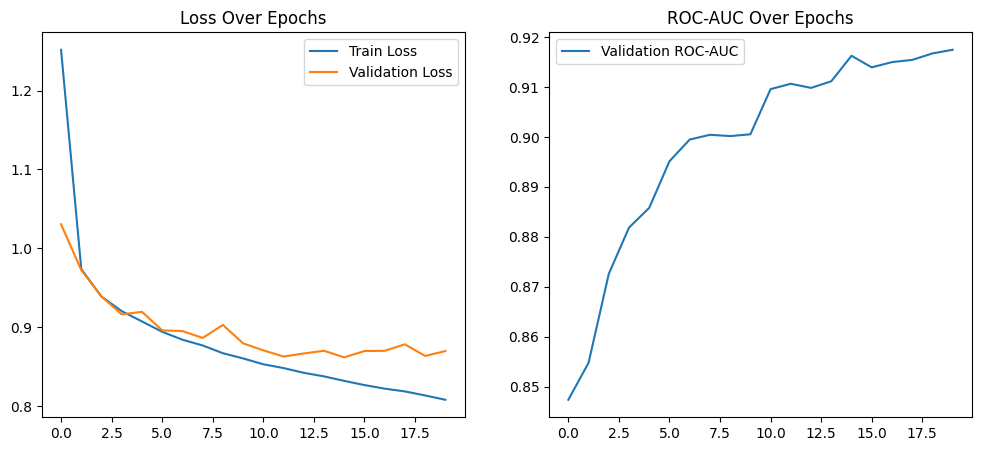

In [78]:
# Строим графики ошибок

print(max(val_aucs))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_aucs, label='Validation ROC-AUC')
plt.title('ROC-AUC Over Epochs')
plt.legend()
plt.show()

#### Предикт на тесте нейронкой

In [79]:
# Загружаем самое лучшее состояние модели

model.load_state_dict(torch.load(PATH+'best_model_nn.pth'))
model = model.to(device)

In [80]:
# Подготовка данных
for col in category_cols:
    test_df[col] = test_df[col].astype('category').cat.codes

test_df['end_cluster'] = 0
test_df = test_df[test_df["date"] == "month_6"]

sample_submission_df = pd.read_csv(PATH+"/sample_submission.csv")

predictions = test_df[['id']].copy()
predictions.reset_index(drop=True, inplace=True)

classes_cols = sorted(sample_submission_df.columns.to_list())
classes_cols.remove('id')
predictions[classes_cols] = 0.0

test_dataset = ClassificationDataset(test_df, category_cols, numeric_cols, target_col)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [81]:
# Сам предикт

model.eval()
all_targets = []
all_predictions = []
with torch.no_grad():
    for cat_data, num_data, targets in tqdm(test_loader):
        cat_data = cat_data.to(device)
        num_data = num_data.to(device)
        targets = targets.to(device)

        outputs = model(cat_data, num_data)

        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(probabilities)

print(len(all_predictions), all_predictions[0].shape)

test_pred_proba_df = pd.DataFrame(all_predictions, columns=list(label_encoder.classes_))
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]
predictions[classes_cols] += test_pred_proba_df[classes_cols]

  0%|          | 0/98 [00:00<?, ?it/s]

100000 (17,)


In [82]:
predictions.head(3)

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.014295,0.001474,0.018549,0.061466,0.001967,0.000227,0.000650,3.189410e-04,0.008461,0.006554,0.023306,0.002782,0.000937,8.800902e-06,0.002540,0.856460,0.000005
1,200001,0.010699,0.629940,0.000025,0.000104,0.000021,0.000047,0.000017,8.446922e-07,0.000109,0.002616,0.000210,0.000002,0.000062,9.019072e-09,0.000030,0.356116,0.000001
2,200002,0.927264,0.000169,0.002409,0.010013,0.001489,0.000973,0.000078,1.090575e-02,0.005366,0.013081,0.001144,0.000096,0.000615,6.269646e-09,0.009452,0.016945,0.000001


In [83]:
# Сохраняем предикты нейронки для отправки

predictions.to_csv(PATH+"submission_nn.csv", index=False)

#### Готовим усредненный предикт от катбуста и нейронки

In [84]:
df_nn = pd.read_csv(PATH+'submission_nn.csv')
df_ct = pd.read_csv(PATH+'submission_ctb.csv')

df_nn = df_nn.sort_values(by='id').reset_index(drop=True)
df_ct = df_ct.sort_values(by='id').reset_index(drop=True)

assert all(df_nn['id'] == df_ct['id']), "id не матчатся"

df_average = df_nn.copy()
for col in df_nn.columns:
    if col != 'id':
        df_average[col] = (df_nn[col] + df_ct[col]) / 2

In [85]:
df_average.to_csv(PATH+"submission_avg.csv", index=False)

In [86]:
df_average.head(3)

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.014372,0.007043,0.018345,0.044037,0.006925,0.000278,0.001349,0.000460,0.011467,0.005251,0.029442,0.001615,0.001714,9.050061e-06,0.002311,0.855370,0.000012
1,200001,0.007741,0.574456,0.000247,0.000650,0.000253,0.000038,0.000085,0.000005,0.000534,0.004913,0.000511,0.000097,0.000427,4.885788e-07,0.000243,0.409678,0.000124
2,200002,0.838802,0.000769,0.003499,0.058908,0.004853,0.001126,0.001015,0.008824,0.017852,0.008834,0.005292,0.001747,0.000755,5.657124e-06,0.012095,0.035569,0.000053
